# 03 - Base Model and Custom Metrics

In [2]:
import os, gc, warnings
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from lightgbm import early_stopping, log_evaluation
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

# plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 100


warnings.filterwarnings('ignore')

## Preparing the Data

In [3]:
DATA_PATH = '../data/processed/'     

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, 'transactions_processed.csv'))

In [5]:
test_mask  = (df['year']==2020) & (df['trans_month']==12) 
valid_mask = (df['year']==2020) & (df['trans_month'].between(10,11))
train_mask = ~test_mask & ~valid_mask

train_df, valid_df, test_df = df[train_mask], df[valid_mask], df[test_mask]

## Preprocessing

In [6]:
target = 'is_fraud'
ignore = [target,'transaction_datetime']

features = [c for c in df.columns if c not in ignore]
cat_cols = [c for c in features if df[c].dtype=='object']

#  LightGBM requires categorical features instead of object dtype.
for c in cat_cols:
    for part in (train_df, valid_df, test_df):
        part[c] = part[c].astype('category')

## Base Model

### Utility Functions

In [7]:
def kpi_report(model, df, thr):
    predictions = model.predict(df[features])
    actuals = df[target].values
    is_frequent = df["is_frequent_customer"].values
    predicted_fraud = predictions >= thr

    tp = ((actuals == 1) & predicted_fraud).sum()
    fn = ((actuals == 1) & ~predicted_fraud).sum()
    fp = ((actuals == 0) & predicted_fraud).sum()

    fp_freq = ((actuals == 0) & predicted_fraud & (is_frequent == 1)).sum()
    legitimate_freq = ((actuals == 0) & (is_frequent == 1)).sum()

    recall = tp / (tp + fn)
    fpr = fp / (actuals == 0).sum()
    fpr_freq = fp_freq / legitimate_freq

    fp_tp_ratio_overall = (tp + fp) / tp
    fp_tp_ratio_freq = (tp + fp_freq) / tp

    results = {
        "recall": recall,
        "fpr": fpr,
        "fpr_freq": fpr_freq,
        "fp_tp_ratio_overall": fp_tp_ratio_overall,
        "fp_tp_ratio_freq": fp_tp_ratio_freq
    }
    
    return results

def detailed_evaluation_report(
    model,
    df,
    features,
    target,
    thr=0.5,
    return_dict=False
):
    """
    Prints overall & frequent-customer FP rates,
    classification report, and two heatmaps.
    Returns a dict of metrics if return_dict=True.
    """
    # 1) Predictions
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(df[features])[:, 1]
    else:
        probs = model.predict(df[features])
    preds = (probs >= thr).astype(int)
    y_true = df[target].values
    is_freq = df["is_frequent_customer"].values.astype(bool)

    # 2) Classification report
    print("=== Classification Report ===")
    print(classification_report(y_true, preds, digits=4))

    # 3) Confusion matrix & overall FP rate
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    overall_fp_rate = fp / (tn + fp) if (tn + fp) else 0
    print(f"\nOverall false positives : {fp}")
    print(f"Overall FP rate         : {overall_fp_rate*100:.4f}%")

    # 4) Frequent-customer FP rate
    legit_freq_mask = (~y_true.astype(bool)) & is_freq
    freq_count = legit_freq_mask.sum()
    fp_freq = (preds.astype(bool) & legit_freq_mask).sum()
    if freq_count:
        freq_fp_rate = fp_freq / freq_count
        print("\n=== Frequent-Customer FP ===")
        print(f"False positives (freq)  : {fp_freq}")
        print(f"FP rate (freq)          : {freq_fp_rate*100:.4f}%")
    else:
        freq_fp_rate = 0
        print("\nNo frequent-customer legits to evaluate.")

    # 5) Plots
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    cm_all = confusion_matrix(y_true, preds)
    sns.heatmap(cm_all, annot=True, fmt="d", ax=axes, cmap="Blues")
    axes.set(title="Confusion Matrix", xlabel="Predicted", ylabel="Actual")

    plt.tight_layout()
    plt.show()

    # 6) Return dict if wanted
    results = {
        "overall_fp_rate": overall_fp_rate,
        "overall_fp_count": fp,
        "freq_fp_rate": freq_fp_rate,
        "freq_fp_count": fp_freq,
        "freq_legit_count": freq_count,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
    }
    if return_dict:
        return results


In [8]:
print("Frequent cust. (valid):", valid_df['is_frequent_customer'].mean())
print("Frequent cust. (test):", test_df['is_frequent_customer'].mean())


Frequent cust. (valid): 0.007437510124451519
Frequent cust. (test): 0.04137224268658


### Training

In [9]:
params = dict(
    objective="binary",
    learning_rate=0.05,
    num_leaves=64,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    seed=42,
    verbosity=-1,
    max_depth=10,
    min_child_samples=50,
    # scale_pos_weight=50,
    class_weight='balanced',
    min_child_weight=0.1,
)


base_model = lgb.LGBMClassifier(
    **params,
    n_estimators=500,
    metric="auc"
)

base_model.fit(
    X=train_df[features],
    y=train_df[target],
    sample_weight=None,
    eval_set=[(valid_df[features], valid_df[target])],
    categorical_feature=cat_cols,
    callbacks=[ lgb.early_stopping(50)],
    eval_metric="auc",
)



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.993308


LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, class_weight='balanced',
               feature_fraction=0.8, learning_rate=0.05, max_depth=10,
               metric='auc', min_child_samples=50, min_child_weight=0.1,
               n_estimators=500, num_leaves=64, objective='binary', seed=42,
               verbosity=-1)

In [10]:
import pandas as pd

# Grab the booster (if you trained via the sklearn API)
bst = base_model.booster_ if hasattr(base_model, "booster_") else base_model

# Extract feature names & their importances by split (or “gain”)
fi = pd.DataFrame({
    "feature": bst.feature_name(),
    "importance_split": bst.feature_importance(importance_type="split"),
    "importance_gain":  bst.feature_importance(importance_type="gain"),
})

# Sort and inspect top 20
print(fi.sort_values("importance_gain", ascending=False).head(20))


                            feature  importance_split  importance_gain
46                    amt_std_last5               112     8.258269e+06
3                               amt               499     3.528690e+06
2                          category               392     1.022417e+06
44                 amt_median_last5               155     6.890775e+05
1                          merchant               683     6.807803e+05
49                          log_amt                85     5.467691e+05
50                          amt_bin                39     5.196790e+05
7                            street               504     5.106588e+05
42                amt_dev_from_mean               185     4.617148e+05
41                         hour_cos               285     2.919218e+05
15                              dob               193     2.396919e+05
45             amt_dev_from_median5                73     1.502527e+05
8                              city               152     1.188245e+05
28    

#### Results

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9999    0.9972    0.9985    139280
           1     0.3788    0.9264    0.5377       258

    accuracy                         0.9971    139538
   macro avg     0.6893    0.9618    0.7681    139538
weighted avg     0.9987    0.9971    0.9977    139538


Overall false positives : 392
Overall FP rate         : 0.2814%

=== Frequent-Customer FP ===
False positives (freq)  : 18
FP rate (freq)          : 0.3124%


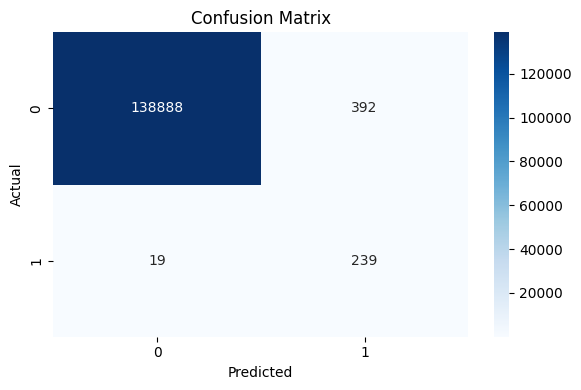

In [11]:
detailed_evaluation_report(base_model, test_df, features, target, 0.5)

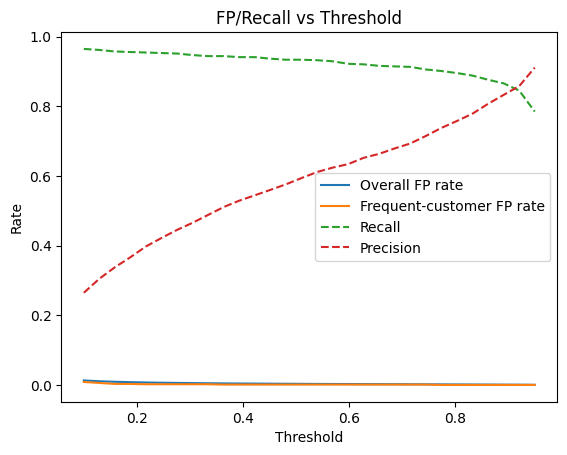

In [12]:
import numpy as np
from sklearn.metrics import precision_recall_curve

probs = base_model.predict_proba(valid_df[features])[:, 1]
y_true = valid_df[target].values
is_freq = valid_df["is_frequent_customer"].values.astype(bool)

thresholds = np.linspace(0.1, 0.95, 30)
fp_rates = []
fp_rates_freq = []
recalls = []
precisions = []

for thr in thresholds:
    preds = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    legit_freq_mask = (~y_true.astype(bool)) & is_freq
    freq_count = legit_freq_mask.sum()
    fp_freq = (preds.astype(bool) & legit_freq_mask).sum()
    fp_rates.append(fp / (tn + fp))
    fp_rates_freq.append(fp_freq / freq_count if freq_count else 0)
    recalls.append(tp / (tp + fn))
    precisions.append(tp / (tp + fp) if (tp + fp) else 0)

import matplotlib.pyplot as plt

plt.plot(thresholds, fp_rates, label='Overall FP rate')
plt.plot(thresholds, fp_rates_freq, label='Frequent-customer FP rate')
plt.plot(thresholds, recalls, label='Recall', linestyle='--')
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("FP/Recall vs Threshold")
plt.show()


In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Use your model's predicted probabilities on the validation set
probs = base_model.predict_proba(valid_df[features])[:, 1]
y_true = valid_df[target].values
is_freq = valid_df["is_frequent_customer"].values.astype(bool)

thresholds = np.linspace(0.1, 0.95, 30)

rows = []
for thr in thresholds:
    preds = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    # overall FP rate
    overall_fp_rate = fp / (tn + fp) if (tn + fp) else 0
    # frequent-customer FP rate
    legit_freq_mask = (~y_true.astype(bool)) & is_freq
    freq_count = legit_freq_mask.sum()
    fp_freq = (preds.astype(bool) & legit_freq_mask).sum()
    freq_fp_rate = fp_freq / freq_count if freq_count else 0
    # recall/precision
    recall = tp / (tp + fn) if (tp + fn) else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    rows.append({
        "threshold": thr,
        "recall": recall,
        "precision": precision,
        "overall_fp_rate": overall_fp_rate,
        "fp_rate_frequent_customer": freq_fp_rate,
        "overall_fp_count": fp,
        "fp_count_frequent_customer": fp_freq,
        "tp": tp,
        "fn": fn
    })

table = pd.DataFrame(rows)

# Find threshold with highest F1 score (harmonic mean of precision and recall)
table['f1'] = 2 * (table['precision'] * table['recall']) / (table['precision'] + table['recall'])
best_threshold_idx = table['f1'].idxmax()
best_row = table.iloc[best_threshold_idx]

print("\nBest threshold based on F1 score:")
print(f"Threshold: {best_row['threshold']:.3f}")
print(f"F1 Score: {best_row['f1']:.3f}")
print(f"Precision: {best_row['precision']:.3f}")
print(f"Recall: {best_row['recall']:.3f}")
print(f"FP Rate (Overall): {best_row['overall_fp_rate']:.3f}")
print(f"FP Rate (Frequent Customers): {best_row['fp_rate_frequent_customer']:.3f}")



Best threshold based on F1 score:
Threshold: 0.921
F1 Score: 0.851
Precision: 0.858
Recall: 0.845
FP Rate (Overall): 0.001
FP Rate (Frequent Customers): 0.000


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9996    0.9994    0.9995    139280
           1     0.7199    0.7868    0.7519       258

    accuracy                         0.9990    139538
   macro avg     0.8597    0.8931    0.8757    139538
weighted avg     0.9991    0.9990    0.9991    139538


Overall false positives : 79
Overall FP rate         : 0.0567%

=== Frequent-Customer FP ===
False positives (freq)  : 3
FP rate (freq)          : 0.0521%


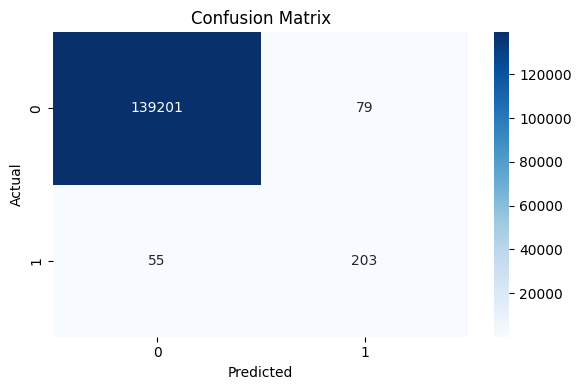

In [24]:
detailed_evaluation_report(base_model, test_df, features, target, 0.921)


## Custom Metrics

In [15]:
def make_weights(part, legit_freq_w=10.0):
    """Boost loss on legitimate frequent‑customer rows."""
    w = np.ones(len(part))
    mask = (part['is_frequent_customer'] == 1) & (part[target] == 0)
    w[mask] = legit_freq_w         
    return w

w_train = make_weights(train_df, 7.5)
w_valid = make_weights(valid_df, 7.5)

In [16]:
lgb_train = lgb.Dataset(
    train_df[features],
    label=train_df[target],
    weight=w_train,
    categorical_feature=cat_cols,
    free_raw_data=False,
)
lgb_valid = lgb.Dataset(
    valid_df[features],
    label=valid_df[target],
    weight=w_valid,
    categorical_feature=cat_cols,
    free_raw_data=False,
    reference=lgb_train,
)

In [17]:
freq_map = {
    id(lgb_train): train_df["is_frequent_customer"].values,
    id(lgb_valid): valid_df["is_frequent_customer"].values,
}

In [18]:
def fp_tp_ratio(preds, data):
    """
    Custom metric: (TP + FP) / TP
    Lower is better. Measures overall alert burden relative to true positives
    """
    y_true  = data.get_label()
    y_pred  = preds > 0.50            # fixed cut-off inside metric
    tp      = ((y_true==1) & y_pred).sum()
    fp      = ((y_true==0) & y_pred).sum()
    ratio   = (tp + fp) / tp if tp else np.inf
    return 'fp_tp_ratio', ratio, False


def balanced_cost(preds, data, w_fp=3.0, w_fn=10.0):
    """
    Custom cost: w_fp * FP_on_frequent + w_fn * FN
    Lower is better. Balances penalties for missing fraud vs. false alerts on frequent customers
    """
    y_true = data.get_label()
    freq   = freq_map[id(data)]
    y_pred = preds > 0.50

    fp_freq = ((y_true==0) & y_pred & (freq==1)).sum()
    fn      = ((y_true==1) & ~y_pred).sum()
    cost    = w_fp * fp_freq + w_fn * fn
    return 'balanced_cost', cost, False


def f05_score(preds, data):
    """
    Custom F-beta score (beta=0.5), negated for maximization.
    Higher is better. Emphasizes precision (FP control) twice as much as recall.
    """
    y_true = data.get_label()
    y_pred = preds > 0.50
    tp = ((y_true==1) & y_pred).sum()
    fp = ((y_true==0) & y_pred).sum()
    fn = ((y_true==1) & ~y_pred).sum()

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall    = tp / (tp + fn) if (tp + fn) else 0
    beta2 = 0.25         # beta^2 = (0.5)^2
    score = (1 + beta2) * precision * recall / (beta2 * precision + recall) if (precision+recall) else 0
    return 'f05_score', -score, True  # negative because LGBM expects lower-is-worse True


def freq_fpr(preds, data):
    """
    Frequent-customer false-positive rate: FP_freq / Legit_freq
    Lower is better. Measures share of frequent customers erroneously flagged
    """
    y_true = data.get_label()
    freq   = freq_map[id(data)]
    y_pred = preds > 0.50

    fp_freq   = ((y_true==0) & y_pred & (freq==1)).sum()
    legit_freq = ((y_true==0) & (freq==1)).sum()
    fpr = fp_freq / legit_freq if legit_freq else 0
    return 'freq_fpr', fpr, False

In [19]:
metrics = [fp_tp_ratio, balanced_cost, f05_score, freq_fpr]

def run_and_log(feval_fn, legit_freq_w=10.0):
    w_train = make_weights(train_df, legit_freq_w)
    w_valid = make_weights(valid_df, legit_freq_w)
    lgb_train.set_weight(w_train)
    lgb_valid.set_weight(w_valid)
    

    print(f"\n -> {feval_fn.__name__}")

    params = dict(
        objective="binary",
        learning_rate=0.05,
        num_leaves=64,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        seed=42,
        verbosity=-1,
        # scale_pos_weight=50,
        min_child_weight=0.1,
        is_unbalance=True  # This enables balanced class weights
    )

    mdl = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_valid],
        valid_names=["valid"],
        feval=feval_fn,
        num_boost_round=500,
        callbacks=[early_stopping(50)],
    )

    best = mdl.best_score["valid"][feval_fn.__name__]
    return mdl, best


results = {}
models = {}
for fe in metrics:
    model, score = run_and_log(fe, legit_freq_w=10)  
    results[fe.__name__] = score
    models[fe.__name__] = model 


 -> fp_tp_ratio
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's binary_logloss: 0.00484308	valid's fp_tp_ratio: 1.09287

 -> balanced_cost
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid's binary_logloss: 0.0485932	valid's balanced_cost: 271

 -> f05_score
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.0679842	valid's f05_score: -0.254475

 -> freq_fpr
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid's binary_logloss: 0.00869315	valid's freq_fpr: 0



Model: fp_tp_ratio
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998    139280
           1     0.9401    0.7907    0.8589       258

    accuracy                         0.9995    139538
   macro avg     0.9699    0.8953    0.9294    139538
weighted avg     0.9995    0.9995    0.9995    139538


Overall false positives : 13
Overall FP rate         : 0.0093%

=== Frequent-Customer FP ===
False positives (freq)  : 0
FP rate (freq)          : 0.0000%


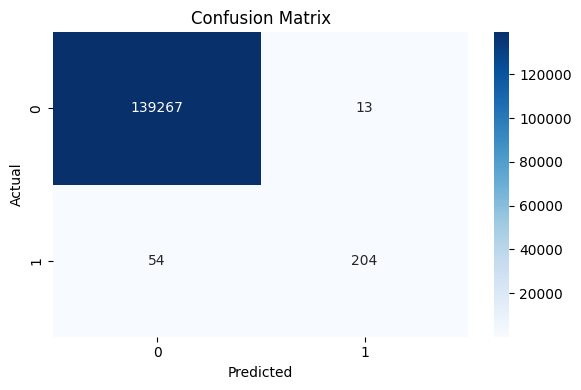


Model: balanced_cost
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9998    0.9911    0.9954    139280
           1     0.1589    0.9109    0.2706       258

    accuracy                         0.9909    139538
   macro avg     0.5794    0.9510    0.6330    139538
weighted avg     0.9983    0.9909    0.9941    139538


Overall false positives : 1244
Overall FP rate         : 0.8932%

=== Frequent-Customer FP ===
False positives (freq)  : 49
FP rate (freq)          : 0.8505%


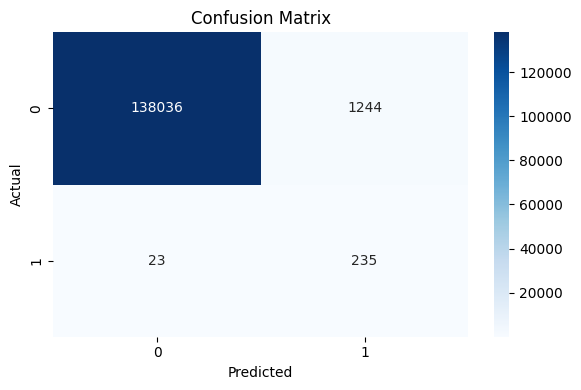


Model: f05_score
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9999    0.9856    0.9927    139280
           1     0.1084    0.9457    0.1946       258

    accuracy                         0.9855    139538
   macro avg     0.5542    0.9657    0.5936    139538
weighted avg     0.9982    0.9855    0.9912    139538


Overall false positives : 2006
Overall FP rate         : 1.4403%

=== Frequent-Customer FP ===
False positives (freq)  : 72
FP rate (freq)          : 1.2498%


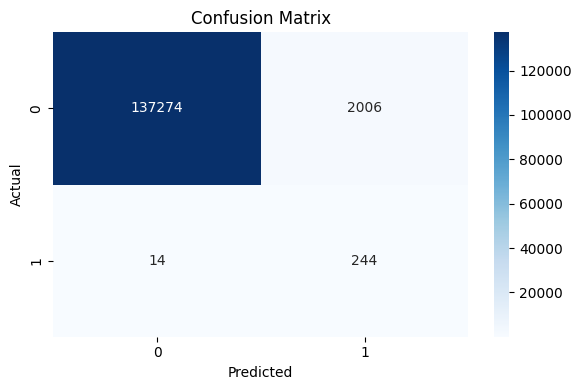


Model: freq_fpr
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9996    0.9995    0.9996    139280
           1     0.7500    0.7791    0.7643       258

    accuracy                         0.9991    139538
   macro avg     0.8748    0.8893    0.8819    139538
weighted avg     0.9991    0.9991    0.9991    139538


Overall false positives : 67
Overall FP rate         : 0.0481%

=== Frequent-Customer FP ===
False positives (freq)  : 0
FP rate (freq)          : 0.0000%


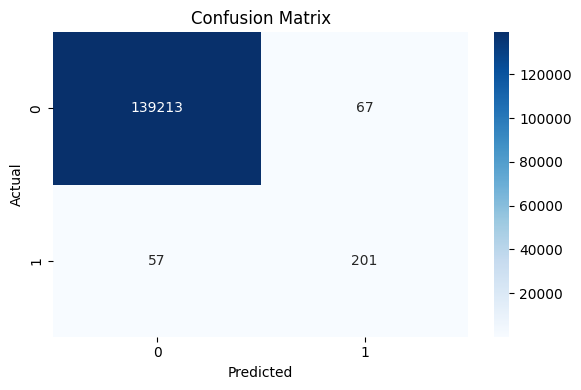

In [20]:
for model_name, model in models.items():
     print(f"\nModel: {model_name}")
     detailed_evaluation_report(model, test_df, features, target, 0.9)